I dati utilizzati in questo notebook sono stati presi dalla competizione di Analytics Vidhya [Practice Problem: Big Mart Sales III](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/#data_dictionary).

### Riferimenti bibliografici:

* Azzalini, A. &  Scarpa B. (2012), [Data Analysis and Data Mining: An Introduction](https://global.oup.com/academic/product/data-analysis-and-data-mining-9780199767106?q=Data%20Mining&lang=en&cc=it).
* Hastie, T.; Tibshirani, R. & Friedman, J. (2009), [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/).

# Regressione stepwise, Ridge e LASSO

## Indice

1. [Alcune definizioni utili](#definizioni)<br>
2. [Decidere la metrica di valutazione](#metrica)<br>
3. [Creare una baseline](#baseline)<br>
    3.1 [`DummyRegressor`](#dummy_regressor)<br>
    3.2 [Regressione lineare](#regressione_lineare)<br>
4. [Regressione stepwise](#stepwise)<br>
5. [Ridge](#ridge)<br>
    5.1 [Selezione dell'iperparametero `alpha`](#alpha_ridge)<br>
    5.2 [Risultati dell'esperimento](#risultati_ridge)<br>
6. [LASSO (Least Absolute Shrinkage and Selection Operator)](#lasso)<br>
    6.1 [Selezione dell'iperparametro `alpha`](#alpha_lasso)<br>
    6.2 [Risultati dell'esperimento](#risultati_lasso)<br>
7. [Valutare le performance sull'insieme di test](#performance_test)<br>
8. [Utilizzare il modello su dati nuovi](#dati_nuovi)<br>
    8.1 [Utilizzare la pipeline di preprocessamento e lo stimatore già allenati](#allenati)<br>
    8.2 [Riallenare la pipeline da zero e prevedere le vendite per i nuovi dati](#riallenare)<br>

In [2]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

I dati utilizzati in questo notebook sono stati presi dalla competizione di Analytics Vidhya [Practice Problem: Big Mart Sales III](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/#data_dictionary).

> Nota: i dati originali sono già stati preprocessati ad organizzati per l'analisi inferenziale e predittiva. L'approfondimento sull'analisi esplorativa ed il preprocessamento dei dati verrà affontato in un secondo momento.

### Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

### Data

We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.

|**Variable**                 | Description                                              |
|-----------------------------|----------------------------------------------------------|
|**Item_Identifier**          | Unique product ID                                        |
|**Item_Weight**              | Weight of product                                        |
|**Item_Fat_Content**         | Whether the product is low fat or not                    |
|**Item_Visibility**          | The % of total display area of all products in a store allocated<br/>to the particular product|
|**Item_Type**                |The category to which the product belongs                 |
|**Item_MRP**                 |Maximum Retail Price (list price) of the product          |
|**Outlet_Identifier**        |Unique store ID                                           |
|**Outlet_Establishment_Year**|The year in which store was established                   |
|**Outlet_Size**              |The size of the store in terms of ground area covered     |
|**Outlet_Location_Type**     |The type of city in which the store is located            |
|**Outlet_Type**              |Whether the outlet is just a grocery store or some sort of<br/>supermarket|
|**Item_Outlet_Sales**        |Sales of the product in the particulat store. This is the outcome variable<br/>to be predicted|

In [3]:
# Estratto dei dati originali
PATH = "msbd/datasets/big_mart_sales" # cambiare in base a dove si è salvato il dataset

dati = pd.read_csv(PATH + "/Train_UWu5bXk.csv")
print("Dimensione del dataset: {} x {}".format(*dati.shape))
dati.head()

Dimensione del dataset: 8523 x 12


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
PATH = "msbd/output/07"

X_train = pd.read_pickle(PATH + "/X_train.pkl")
X_val = pd.read_pickle(PATH + "/X_val.pkl")
X_test = pd.read_pickle(PATH + "/X_test.pkl")
y_train = pd.read_pickle(PATH + "/y_train.pkl")
y_val = pd.read_pickle(PATH + "/y_val.pkl")
y_test = pd.read_pickle(PATH + "/y_test.pkl")

In [6]:
print("""Dimensione dei dataset (X)
Training: {}
Validation: {}
Testing: {}""".format(X_train.shape, X_val.shape, X_test.shape))

print("""\nDimensione dei dataset (y)
Training: {}
Validation: {}
Testing: {}""".format(y_train.shape, y_val.shape, y_test.shape))

Dimensione dei dataset (X)
Training: (6523, 39)
Validation: (1000, 39)
Testing: (1000, 39)

Dimensione dei dataset (y)
Training: (6523,)
Validation: (1000,)
Testing: (1000,)


# 1. Alcune definizioni utili <a id=definizioni> </a>

Sia $y_i$ l'osservazione i-esima della variabile risposta, $\overline{y}$ la media degli $y_i$ e $\hat{y}_i$ la stima di $y_i$ data dal modello, si definiscono le seguenti quantità:

**Somma dei quadrati dei residui**:
$$
\mathrm{RSS} = \sum\limits_{i=1}^n(y_i - \hat{y}_i)^2
$$

**Somma dei quadrati totale**:
$$
\mathrm{TSS} = \sum\limits_{i=1}^n(y_i - \overline{y}_i)^2
$$

**Coefficiente di determinazione**:
$$
R^2 = 1 - \frac{\mathrm{RSS}}{\mathrm{TSS}}
$$

**Errore quadratico medio / stima della varianza dei residui**:
$$
\mathrm{MSE} = \hat{\sigma}^2 = \frac{\mathrm{RSS}}{n}
$$

**Radice dell'errore quadratico medio**:
$$
\mathrm{RMSE} = \sqrt{\mathrm{MSE}}
$$

**Criterio d'informazione di Akaike**:
$$
\mathrm{AIC} = 2k - 2\ln(\hat{L})
$$

**Vaolore massimo della log-verosimiglianza, caso errori i.i.d. $\sim{\mathcal{N}}(0,\sigma^2)$**:
$$
\ln{(\hat{L})} = -\frac{n}{2}\ln(2\pi) - \frac{n}{2}\ln({\hat{\sigma}}^2) - \frac{1}{2{\hat{\sigma}}^2}\mathrm{RSS}
$$

# 2. Decidere la metrica di valutazione <a id=metrica> </a>

### Evaluation Metric

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in "SampleSubmission.csv".

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the Root Mean Square Error value to judge your response.

$
RMSE = \sqrt{\frac{\sum_{i=1}^N(Predicted_i - Actual_i)^2}{N}}
$

Where
* $N$: total number of observations
* Predicted: the response entered by user
* Actual: actual values of sales


Also, note that the test data is further divided into Public (25%) and Private (75%) data. Your initial responses will be checked and scored on the Public data. But, the final rankings will be based on score on Private data set. Since this is a practice problem, we will keep declare winners after specific time intervals and refresh the competition.

In [7]:
from msbd.metriche import radice_errore_quadratico_medio

print(inspect.getsource(radice_errore_quadratico_medio))

def radice_errore_quadratico_medio(y_true, y_pred, sample_weight=None,
        multioutput="uniform_average"):
    """Radice dell'errore quadratico medio

    Parameters
    ----------
    y_true : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Estimated target values.
    sample_weight : array-like of shape = (n_samples), optional
        Sample weights.
    multioutput : string in ['raw_values', 'uniform_average']
        or array-like of shape (n_outputs)
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
        'uniform_average' :
            Errors of all outputs are averaged with uniform weight.
    Returns
    -------
    loss : float or ndarray of floats
        A non-negative fl

# 3. Creare una baseline <a id=baseline> </a>

## 3.1 `DummyRegressor` <a id=dummy_regressor> </a>

In [8]:
from sklearn.dummy import DummyRegressor

In [9]:
dr = DummyRegressor(strategy='mean')

dr.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [10]:
print("R2 training: {:.4f}".format(dr.score(X_train, y_train)))
print("R2 validation: {:.4f}".format(dr.score(X_val, y_val)))
print("RMSE training: {:.4f}".format(radice_errore_quadratico_medio(y_train, dr.predict(X_train))))
print("RMSE validation: {:.4f}".format(radice_errore_quadratico_medio(y_val, dr.predict(X_val))))

R2 training: 0.0000
R2 validation: -0.0074
RMSE training: 1702.0611
RMSE validation: 1745.9777


### Esercizio

1. È possibile ottenere un [coefficiente di determinazione](https://it.wikipedia.org/wiki/Coefficiente_di_determinazione) $R^2$ negativo?
2. Ci stupisce che l'$R^2$ sull'insieme di training sia esattamente zero per il DummyRegressor?

## 3.2 Regressione lineare <a id=regressione_lineare> </a>

> Nota: per un'implementazione del modello lineare e un summary più vicini a quelli di R considerare la classe [`OLS()`](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) di [`statsmodels`](https://www.statsmodels.org/stable/index.html).

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
from msbd.grafici import grafico_coefficienti

print(inspect.getsource(grafico_coefficienti))

def grafico_coefficienti(coefficienti, variabili):
    """Grafico dei coefficienti

    Parameters
    ----------
    coefficienti : array-like
        Valori dei coefficienti.
    variabili : array-like
        Nomi delle variabili legate ai coefficienti.

    """
    coef = pd.Series(coefficienti, variabili).sort_values()
    coef.plot(kind='bar', title='Grafico dei coefficienti',
        color=[["tab:blue", "tab:orange"][i] for i in (coef > 0)])
    plt.grid()



Intercetta: 2172.98


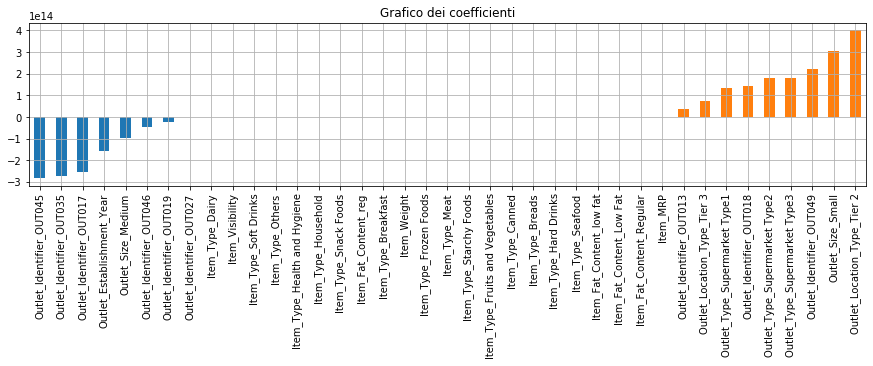

R2 training: 0.5624
R2 validation: 0.5414
RMSE training: 1125.9685
RMSE validation: 1178.0251


In [14]:
plt.figure(figsize=(15, 3))

print("Intercetta: {:.2f}".format(lr.intercept_))
grafico_coefficienti(lr.coef_, X_train.columns)

plt.show()

print("R2 training: {:.4f}".format(lr.score(X_train, y_train)))
print("R2 validation: {:.4f}".format(lr.score(X_val, y_val)))
print("RMSE training: {:.4f}".format(radice_errore_quadratico_medio(y_train, lr.predict(X_train))))
print("RMSE validation: {:.4f}".format(radice_errore_quadratico_medio(y_val, lr.predict(X_val))))

# 4. Regressione stepwise <a id=stepwise> </a>

In [26]:
from msbd.selezione_variabili import Stepwise2

print(inspect.getsource(Stepwise))

class Stepwise(BaseEstimator, RegressorMixin):
    """Regressione stepwise

    Parameters
    ----------
    stimatore : ...

    criterio : ...

    procedura : ...

    verboso : ...

    Attributes
    ----------
    variabili_selezionate_ : ...

    valore_criterio_ : ...

    """
    def __init__(self, stimatore, criterio, procedura,
            verboso=False):
        self.stimatore = stimatore
        self.criterio = criterio
        self.procedura = procedura
        self.verboso = verboso

    def _passo_avanti(self, X, y):
        valore_criterio = float('inf')

        for var in self._variabili_non_incluse:
            nuovo_stimatore = clone(self.stimatore)
            variabili_selezionate = self.variabili_selezionate_ + [var]

            nuovo_stimatore.fit(X[variabili_selezionate], y)

            nuovo_valore_criterio = self.criterio(nuovo_stimatore,
                X[variabili_selezionate], y)
            if nuovo_valore_criterio < valore_criterio:
                v

In [17]:
from msbd.metriche import criterio_informazione_akaike

print(inspect.getsource(criterio_informazione_akaike))

def criterio_informazione_akaike(stimatore, X, y, distribuzione="normale"):
    """Criterio d'informazione di Akaike"""
    n, k = X.shape
    k += 2 # intercetta e deviazione standard
    y_pred = stimatore.predict(X)
    rss = sum((y - y_pred) ** 2)
    var_hat = rss / n

    if distribuzione == "normale":
        logl = (-math.log(2 * math.pi) * n / 2 - math.log(var_hat) * n / 2 -
            rss / (2 * var_hat))
    else:
        ValueError("La distribuzione {} non è attualmente supportata.".format(
            distribuzione))

    return 2 * k - 2 * logl



In [18]:
stepwise = Stepwise(LinearRegression(), criterio_informazione_akaike, "avanti", verboso=True)

stepwise.fit(X_train, y_train)

[INFO] valore criterio: inf
[INFO] numero variabili selezionate: 0
[INFO] variabili selezionate: 

[INFO] valore criterio: 113036.1024
[INFO] numero variabili selezionate: 1
[INFO] variabili selezionate: Item_MRP

[INFO] valore criterio: 112032.1221
[INFO] numero variabili selezionate: 2
[INFO] variabili selezionate: Item_MRP, Outlet_Identifier_OUT027

[INFO] valore criterio: 110991.7275
[INFO] numero variabili selezionate: 3
[INFO] variabili selezionate: Item_MRP, Outlet_Identifier_OUT027, Outlet_Type_Supermarket Type1

[INFO] valore criterio: 110224.8499
[INFO] numero variabili selezionate: 4
[INFO] variabili selezionate: Item_MRP, Outlet_Identifier_OUT027, Outlet_Type_Supermarket Type1, Outlet_Identifier_OUT018

[INFO] valore criterio: 110217.4644
[INFO] numero variabili selezionate: 5
[INFO] variabili selezionate: Item_MRP, Outlet_Identifier_OUT027, Outlet_Type_Supermarket Type1, Outlet_Identifier_OUT018, Outlet_Identifier_OUT045

[INFO] valore criterio: 110213.6727
[INFO] numero v

### Esercizio

L'implementazione del metodo `_selezione_avanti()` della classe `Stepwise` è generico ma computazionalmente oneroso, ad ogni chiamata di `_passo_avanti()` viene riallenato il modello una volta per ogni variabile considerata in quel passo.

1. Sia $n=49$ il numero di variabili a disposizione (come nel nostro caso). Al massimo quante volte viene allenato il modello?
2. Sia sempre $n=49$. Quanti sono tutti i possibili sottoinsiemi di variabili (vedi *best subset selection*...)?
> n_sottoinsiemi = $\sum _{i=0}^{n}$ $_{n}C_{i} = 2^{n}$

Intercetta: 2170.91


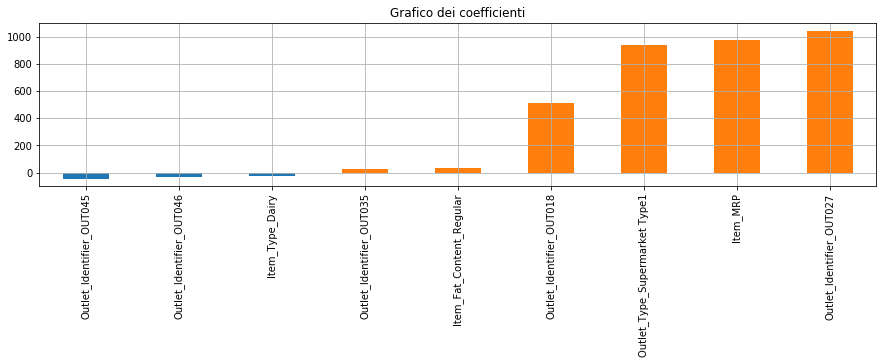

R2 training: 0.5618
R2 validation: 0.5422
RMSE training: 1126.6459
RMSE validation: 1177.0539


In [19]:
plt.figure(figsize=(15, 3))

print("Intercetta: {:.2f}".format(stepwise.stimatore_.intercept_))
grafico_coefficienti(
    stepwise.stimatore_.coef_,
    stepwise.variabili_selezionate_
)

plt.show()

print("R2 training: {:.4f}".format(stepwise.score(X_train, y_train)))
print("R2 validation: {:.4f}".format(stepwise.score(X_val, y_val)))
print("RMSE training: {:.4f}".format(radice_errore_quadratico_medio(y_train, stepwise.predict(X_train))))
print("RMSE validation: {:.4f}".format(radice_errore_quadratico_medio(y_val, stepwise.predict(X_val))))

### Esercizio

1. Completare i metodi `_passo_indietro()` e `_selezione_indietro()`;
2. Ripetere l'esercizio con `procedura="indietro"`. Si ottiene lo stesso insieme di variabili che con `procedura="avanti"`?

In [31]:
stepwise = Stepwise(LinearRegression(), criterio_informazione_akaike, "indietro", verboso=True)

stepwise.fit(X_train, y_train)

[INFO] valore criterio: inf
[INFO] numero variabili selezionate: 39
[INFO] variabili selezionate: Item_MRP, Item_Visibility, Item_Weight, Outlet_Establishment_Year, Item_Fat_Content_Low Fat, Item_Fat_Content_Regular, Item_Fat_Content_low fat, Item_Fat_Content_reg, Item_Type_Breads, Item_Type_Breakfast, Item_Type_Canned, Item_Type_Dairy, Item_Type_Frozen Foods, Item_Type_Fruits and Vegetables, Item_Type_Hard Drinks, Item_Type_Health and Hygiene, Item_Type_Household, Item_Type_Meat, Item_Type_Others, Item_Type_Seafood, Item_Type_Snack Foods, Item_Type_Soft Drinks, Item_Type_Starchy Foods, Outlet_Identifier_OUT013, Outlet_Identifier_OUT017, Outlet_Identifier_OUT018, Outlet_Identifier_OUT019, Outlet_Identifier_OUT027, Outlet_Identifier_OUT035, Outlet_Identifier_OUT045, Outlet_Identifier_OUT046, Outlet_Identifier_OUT049, Outlet_Location_Type_Tier 2, Outlet_Location_Type_Tier 3, Outlet_Size_Medium, Outlet_Size_Small, Outlet_Type_Supermarket Type1, Outlet_Type_Supermarket Type2, Outlet_Type_S

[INFO] valore criterio: 110241.8682
[INFO] numero variabili selezionate: 30
[INFO] variabili selezionate: Item_MRP, Item_Visibility, Item_Weight, Item_Fat_Content_Low Fat, Item_Fat_Content_Regular, Item_Fat_Content_low fat, Item_Fat_Content_reg, Item_Type_Breads, Item_Type_Breakfast, Item_Type_Canned, Item_Type_Dairy, Item_Type_Fruits and Vegetables, Item_Type_Hard Drinks, Item_Type_Health and Hygiene, Item_Type_Household, Item_Type_Meat, Item_Type_Others, Item_Type_Seafood, Item_Type_Snack Foods, Item_Type_Soft Drinks, Item_Type_Starchy Foods, Outlet_Identifier_OUT013, Outlet_Identifier_OUT018, Outlet_Identifier_OUT019, Outlet_Identifier_OUT027, Outlet_Identifier_OUT035, Outlet_Identifier_OUT045, Outlet_Identifier_OUT046, Outlet_Identifier_OUT049, Outlet_Location_Type_Tier 3

[INFO] valore criterio: 110239.8683
[INFO] numero variabili selezionate: 29
[INFO] variabili selezionate: Item_MRP, Item_Visibility, Item_Fat_Content_Low Fat, Item_Fat_Content_Regular, Item_Fat_Content_low fat, I

[INFO] valore criterio: 110217.8247
[INFO] numero variabili selezionate: 17
[INFO] variabili selezionate: Item_MRP, Item_Visibility, Item_Fat_Content_Low Fat, Item_Fat_Content_Regular, Item_Fat_Content_low fat, Item_Type_Dairy, Item_Type_Others, Item_Type_Seafood, Item_Type_Soft Drinks, Outlet_Identifier_OUT013, Outlet_Identifier_OUT018, Outlet_Identifier_OUT019, Outlet_Identifier_OUT027, Outlet_Identifier_OUT035, Outlet_Identifier_OUT045, Outlet_Identifier_OUT046, Outlet_Location_Type_Tier 3

[INFO] valore criterio: 110216.2692
[INFO] numero variabili selezionate: 16
[INFO] variabili selezionate: Item_MRP, Item_Visibility, Item_Fat_Content_Low Fat, Item_Fat_Content_Regular, Item_Fat_Content_low fat, Item_Type_Dairy, Item_Type_Seafood, Item_Type_Soft Drinks, Outlet_Identifier_OUT013, Outlet_Identifier_OUT018, Outlet_Identifier_OUT019, Outlet_Identifier_OUT027, Outlet_Identifier_OUT035, Outlet_Identifier_OUT045, Outlet_Identifier_OUT046, Outlet_Location_Type_Tier 3

[INFO] valore criter

# 5. Ridge <a id=ridge> </a>

In [32]:
from sklearn.linear_model import Ridge

In [33]:
from msbd.esperimenti import esperimento_regolarizzazione

print(inspect.getsource(esperimento_regolarizzazione))

def esperimento_regolarizzazione(stimatore, alpha_list, X_train, y_train,
        X_val, y_val):
    variabili = X_train.columns
    esperimento = pd.DataFrame(columns=variabili)
    r2_train_list = []
    r2_val_list = []
    rmse_train_list = []
    rmse_val_list = []

    for alpha in alpha_list:
        stimatore.set_params(alpha=alpha)
        stimatore.fit(X_train, y_train)
        esperimento = esperimento.append(pd.DataFrame([stimatore.coef_],
            columns=variabili))

        plt.figure(figsize=(15, 3))

        print("\n" + "-" * 79)
        print("Alpha: {} |".format(alpha))
        print("-" * len(str("Alpha: {} -".format(alpha))) + "\n")

        print("Intercetta: {:.2f}".format(stimatore.intercept_))
        grafico_coefficienti(
            stimatore.coef_,
            variabili
        )

        plt.show()

        r2_train = stimatore.score(X_train, y_train)
        r2_val = stimatore.score(X_val, y_val)
        rmse_train = radice_errore_quadratico_medio(y_tr

## 5.1 Selezione dell'iperparametro `alpha` <a id=alpha_ridge> </a>


-------------------------------------------------------------------------------
Alpha: 0.01 |
-------------

Intercetta: 2171.06


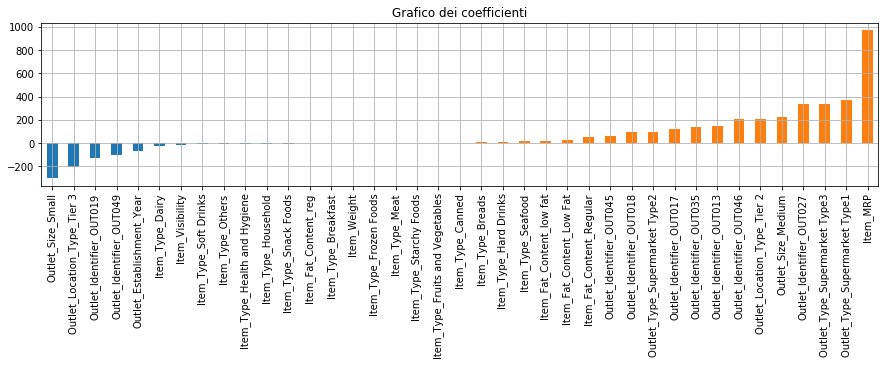

R2 training: 0.5624
R2 validation: 0.5414
RMSE training: 1125.9682
RMSE validation: 1178.0327

-------------------------------------------------------------------------------
Alpha: 0.1 |
------------

Intercetta: 2171.06


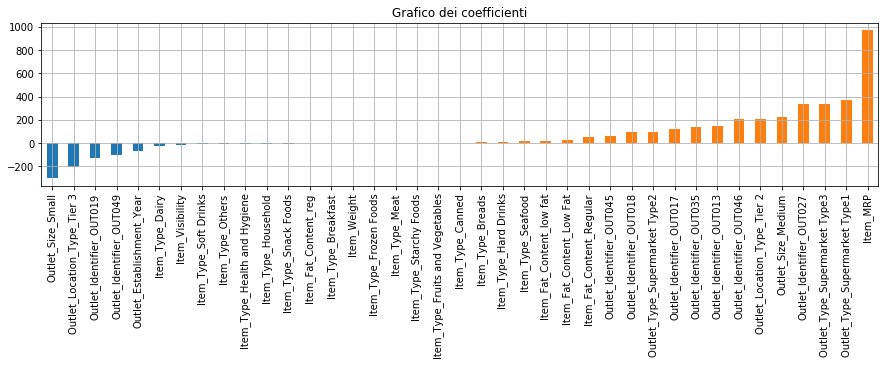

R2 training: 0.5624
R2 validation: 0.5414
RMSE training: 1125.9682
RMSE validation: 1178.0331

-------------------------------------------------------------------------------
Alpha: 1.0 |
------------

Intercetta: 2171.06


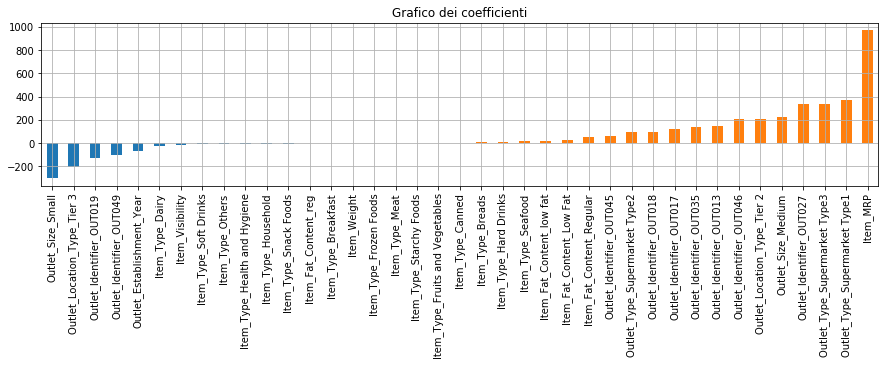

R2 training: 0.5624
R2 validation: 0.5414
RMSE training: 1125.9683
RMSE validation: 1178.0370

-------------------------------------------------------------------------------
Alpha: 10.0 |
-------------

Intercetta: 2171.06


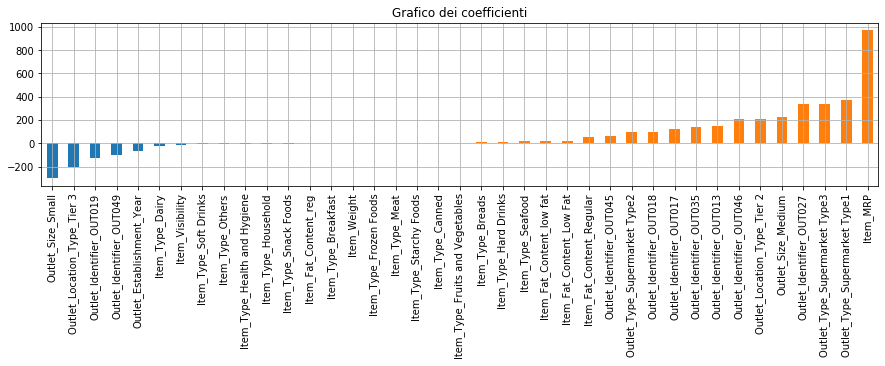

R2 training: 0.5624
R2 validation: 0.5414
RMSE training: 1125.9708
RMSE validation: 1178.0779

-------------------------------------------------------------------------------
Alpha: 100.0 |
--------------

Intercetta: 2171.08


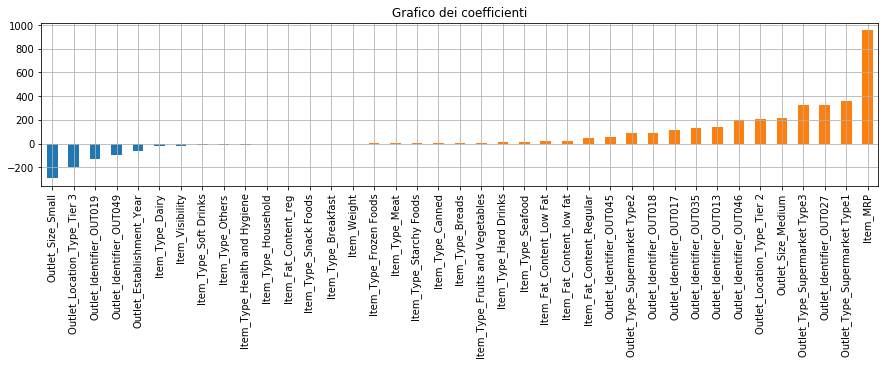

R2 training: 0.5622
R2 validation: 0.5409
RMSE training: 1126.2142
RMSE validation: 1178.6788

-------------------------------------------------------------------------------
Alpha: 1000.0 |
---------------

Intercetta: 2171.24


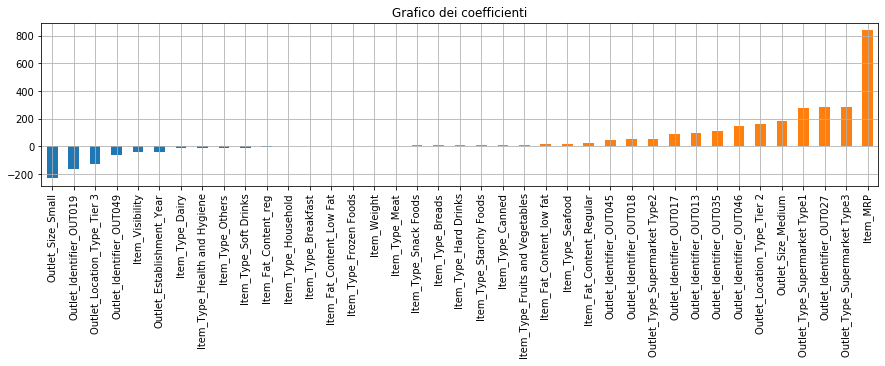

R2 training: 0.5502
R2 validation: 0.5275
RMSE training: 1141.4845
RMSE validation: 1195.7717

-------------------------------------------------------------------------------
Alpha: 10000.0 |
----------------

Intercetta: 2170.92


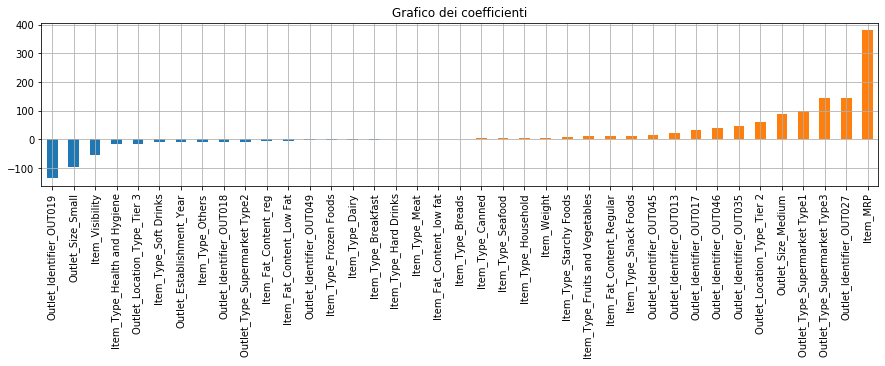

R2 training: 0.3699
R2 validation: 0.3500
RMSE training: 1351.1012
RMSE validation: 1402.5472


In [34]:
alpha_list = [1e-2, 1e-1, 1e-0, 1e+1, 1e+2, 1e+3, 1e+4]

esperimento = esperimento_regolarizzazione(Ridge(), alpha_list, X_train, y_train, X_val, y_val)

## 5.2 Risultati dell'esperimento <a id=risultati_ridge> </a>

### $R^2$ e $\mathrm{RMSE}$

In [35]:
esperimento[["R2_Train", "R2_Val", "RMSE_Train", "RMSE_Val"]]

,R2_Train,R2_Val,RMSE_Train,RMSE_Val
Alpha,,,,
0.01,0.562375,0.541413,1125.968232,1178.032692
0.1,0.562375,0.541413,1125.968232,1178.033078
1.0,0.562375,0.541410,1125.968258,1178.036965
10.0,0.562373,0.541378,1125.970842,1178.077889
100.0,0.562184,0.540910,1126.214201,1178.678838
1000.0,0.550231,0.527498,1141.484451,1195.771726
10000.0,0.369877,0.349957,1351.101230,1402.547211


### Coefficienti stimati al variare di `alpha`

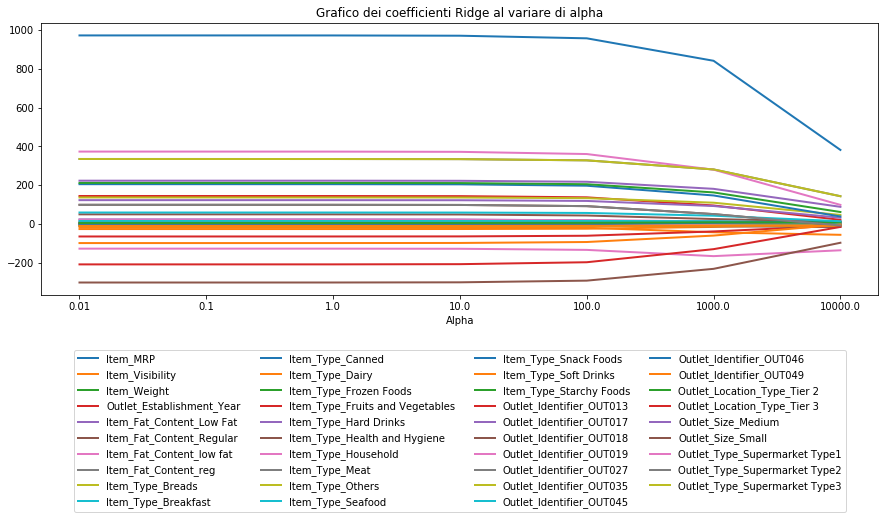

In [36]:
ax = esperimento[X_train.columns].plot(figsize=(15, 5), legend=None, title="Grafico dei coefficienti Ridge al variare di alpha", use_index=False, lw=2)
plt.xticks(range(len(alpha_list)), alpha_list)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.5), ncol=4)
plt.xlabel("Alpha")

plt.show()

# 6. LASSO (Least Absolute Shrinkage and Selection Operator) <a id=lasso> </a>

In [37]:
from sklearn.linear_model import Lasso

## 6.1 Selezione dell'iperparametro `alpha` <a id=alpha_lasso> </a>

C:\Users\Lorenzo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478754753.2842016, tolerance: 1889720.8744539376
  positive)



-------------------------------------------------------------------------------
Alpha: 0.001 |
--------------

Intercetta: 2171.06


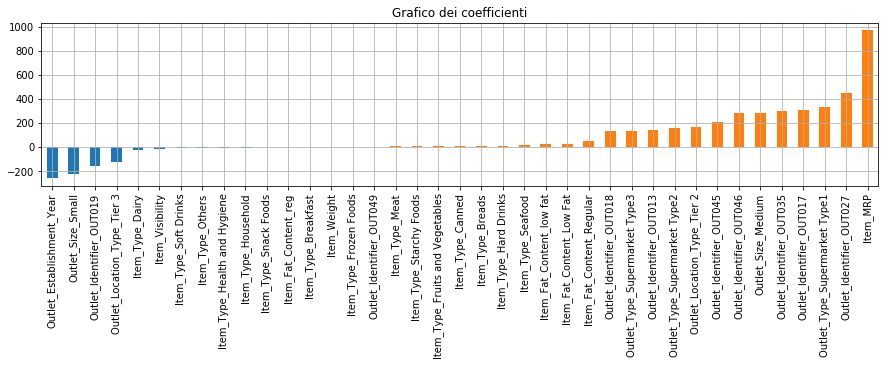

R2 training: 0.5624
R2 validation: 0.5414
RMSE training: 1125.9682
RMSE validation: 1178.0324


C:\Users\Lorenzo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208504161.34358883, tolerance: 1889720.8744539376
  positive)



-------------------------------------------------------------------------------
Alpha: 0.01 |
-------------

Intercetta: 2171.06


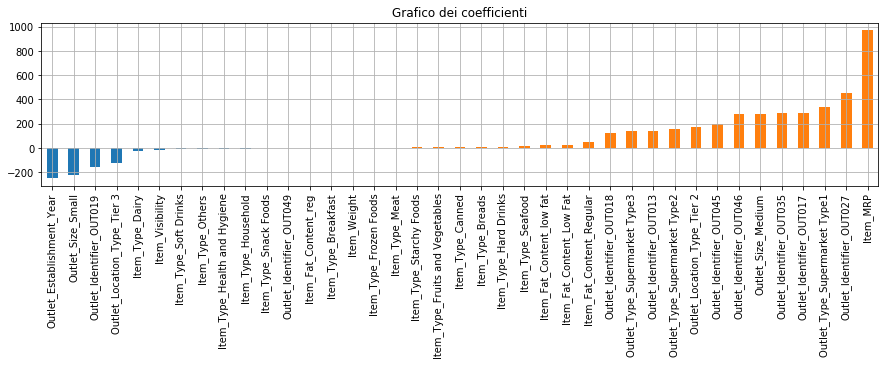

R2 training: 0.5624
R2 validation: 0.5414
RMSE training: 1125.9682
RMSE validation: 1178.0300


C:\Users\Lorenzo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209300617.0080862, tolerance: 1889720.8744539376
  positive)



-------------------------------------------------------------------------------
Alpha: 0.1 |
------------

Intercetta: 2171.05


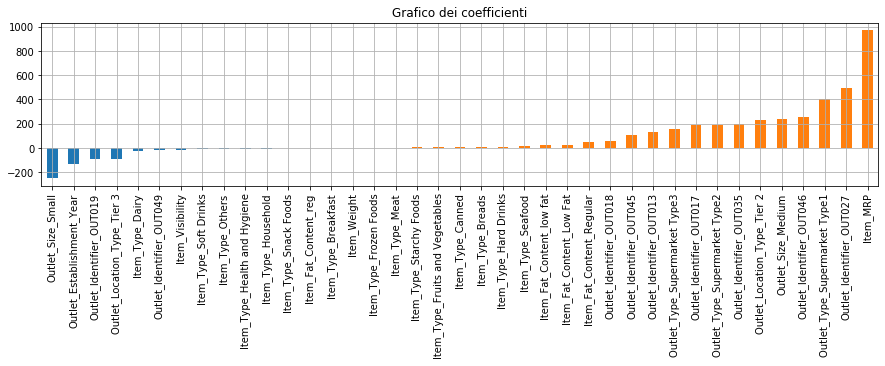

R2 training: 0.5624
R2 validation: 0.5414
RMSE training: 1125.9685
RMSE validation: 1178.0068


C:\Users\Lorenzo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49648628.32654476, tolerance: 1889720.8744539376
  positive)



-------------------------------------------------------------------------------
Alpha: 1.0 |
------------

Intercetta: 2171.02


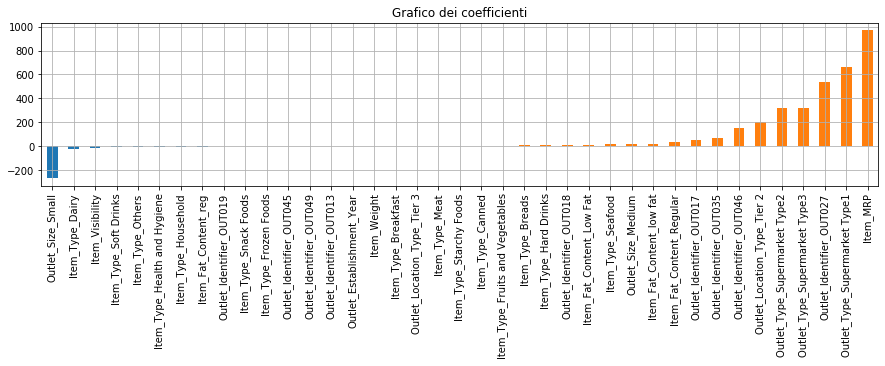

R2 training: 0.5624
R2 validation: 0.5416
RMSE training: 1125.9948
RMSE validation: 1177.7758

-------------------------------------------------------------------------------
Alpha: 10.0 |
-------------

Intercetta: 2171.08


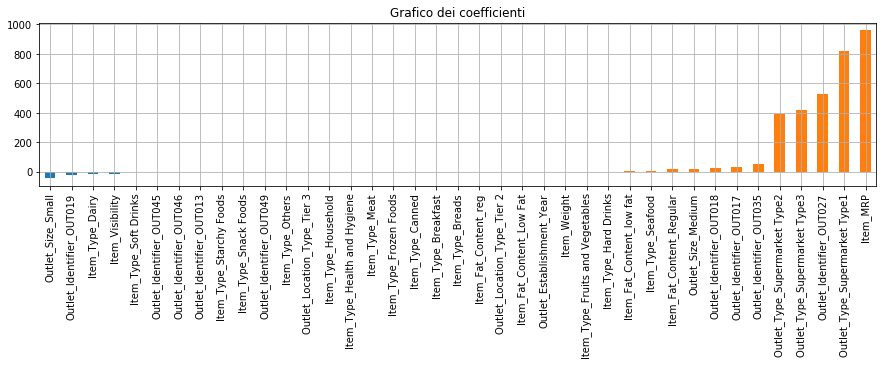

R2 training: 0.5614
R2 validation: 0.5420
RMSE training: 1127.2745
RMSE validation: 1177.2569

-------------------------------------------------------------------------------
Alpha: 100.0 |
--------------

Intercetta: 2171.13


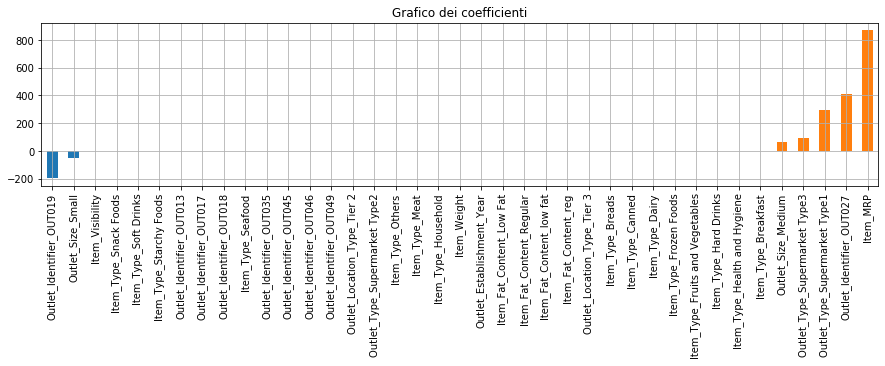

R2 training: 0.5137
R2 validation: 0.4959
RMSE training: 1186.9644
RMSE validation: 1235.0566

-------------------------------------------------------------------------------
Alpha: 1000.0 |
---------------

Intercetta: 2168.94


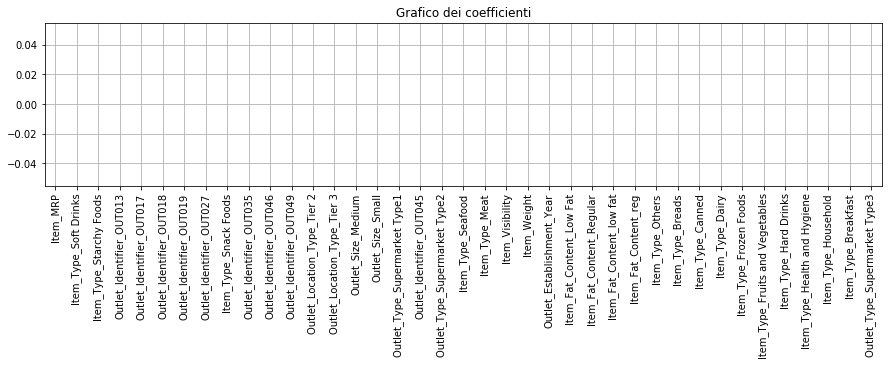

R2 training: 0.0000
R2 validation: -0.0074
RMSE training: 1702.0611
RMSE validation: 1745.9777


In [38]:
alpha_list = [1e-3, 1e-2, 1e-1, 1e-0, 1e+1, 1e+2, 1e+3]

esperimento = esperimento_regolarizzazione(Lasso(), alpha_list, X_train, y_train, X_val, y_val)

## 6.2 Risultati dell'esperimento <a id=risultati_lasso> </a>

### $R^2$ e $\mathrm{RMSE}$

In [39]:
esperimento[["R2_Train", "R2_Val", "RMSE_Train", "RMSE_Val"]]

,R2_Train,R2_Val,RMSE_Train,RMSE_Val
Alpha,,,,
0.001,0.562375,0.541413,1125.968232,1178.032385
0.01,0.562375,0.541415,1125.968235,1178.030036
0.1,0.562375,0.541433,1125.968521,1178.006771
1.0,0.562354,0.541613,1125.994803,1177.775752
10.0,0.561359,0.542017,1127.274499,1177.256949
100.0,0.513677,0.495942,1186.964377,1235.056558
1000.0,0.000000,-0.007360,1702.061080,1745.977656


### Coefficienti stimati al variare di `alpha`

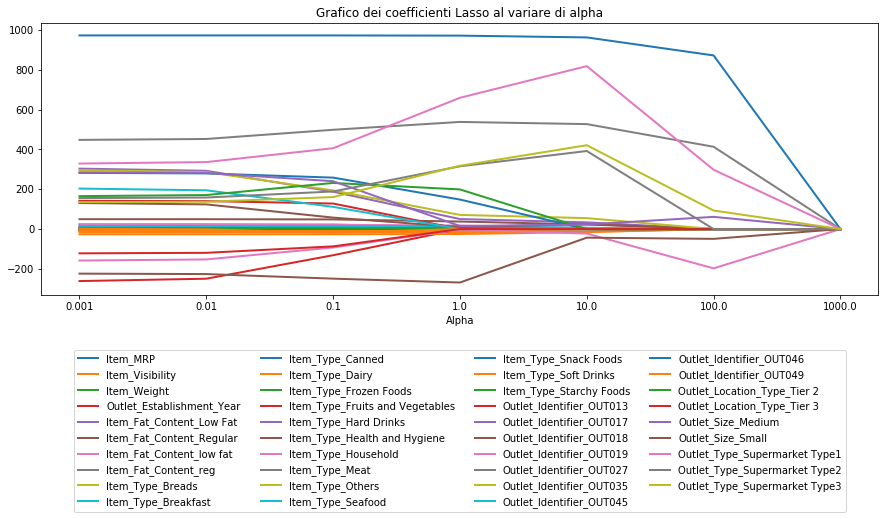

In [40]:
ax = esperimento[X_train.columns].plot(figsize=(15, 5), legend=None, title="Grafico dei coefficienti Lasso al variare di alpha", use_index=False, lw=2)
plt.xticks(range(len(alpha_list)), alpha_list)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.5), ncol=4)
plt.xlabel("Alpha")

plt.show()

# 7. Valutare le performance sull'insieme di test <a id=performance_test> </a>

### Esercizio

Scegliere lo stimatore migliore (ed eventuali iperparametri) tra quelli analizzati.

In [41]:
# valorizzo l'oggetto stimatore con lo stimatore scelto
stimatore = Lasso(alpha=10)

In [42]:
X_trainval = X_train.append(X_val)
y_trainval = y_train.append(y_val)

stimatore.fit(X_trainval, y_trainval)

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [43]:
print("R2 training + validation: {:.4f}".format(stimatore.score(X_trainval, y_trainval)))
print("R2 test: {:.4f}".format(stimatore.score(X_test, y_test)))
print("RMSE training + validation: {:.4f}".format(radice_errore_quadratico_medio(y_trainval, stimatore.predict(X_trainval))))
print("RMSE test: {:.4f}".format(radice_errore_quadratico_medio(y_test, stimatore.predict(X_test))))

R2 training + validation: 0.5592
R2 test: 0.5917
RMSE training + validation: 1133.9289
RMSE test: 1082.7580


# 8. Utilizzare il modello su dati nuovi <a id=dati_nuovi> </a>

### Leggere i dati

In [44]:
# modificare con il path corretto...
PATH = "msbd/datasets/big_mart_sales"

X_new = pd.read_csv(PATH + "/Test_u94Q5KV.csv")
print("Dimensione del dataset: {} x {}".format(*X_new.shape))
X_new.head()

Dimensione del dataset: 5681 x 11


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


## 8.1 Utilizzare la pipeline di preprocessamento e lo stimatore già allenati <a id=allenati> </a>

In [45]:
from sklearn.externals import joblib

C:\Users\Lorenzo\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [47]:
PATH = "msbd/output/07"

pipeline = joblib.load(PATH + "/preproc.joblib")

C:\Users\Lorenzo\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [48]:
pipeline.transform(X_new).head() # non stiamo salvando X_new dopo la trasformazione, serve solo come esempio

,Item_MRP,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,-0.532004,-1.135071,1.695278,0.139533,0.821407,-0.716044,-0.115388,-0.117970,-0.174183,-0.114339,...,-0.349741,-0.349953,2.857194,-0.696637,-0.804685,1.432242,-1.134858,0.726759,-0.34953,-0.351008
1,-0.861870,-0.536929,-0.985019,1.095126,-1.217280,-0.716044,-0.115388,8.475714,-0.174183,-0.114339,...,-0.349741,-0.349953,-0.349953,1.435298,-0.804685,-0.698124,0.881064,0.726759,-0.34953,-0.351008
2,1.617999,0.648145,0.371276,0.020083,0.821407,-0.716044,-0.115388,-0.117970,-0.174183,-0.114339,...,-0.349741,-0.349953,-0.349953,-0.696637,1.242577,-0.698124,0.881064,-1.375810,-0.34953,-0.351008
3,0.225471,-0.983445,-1.197074,1.095126,0.821407,-0.716044,-0.115388,-0.117970,-0.174183,-0.114339,...,-0.349741,-0.349953,-0.349953,1.435298,-0.804685,-0.698124,0.881064,0.726759,-0.34953,-0.351008
4,1.497184,1.016851,0.155991,-1.532756,-1.217280,1.396398,-0.115388,-0.117970,-0.174183,-0.114339,...,-0.349741,-0.349953,-0.349953,-0.696637,1.242577,1.432242,-1.134858,-1.375810,-0.34953,2.848606


In [49]:
pipeline.steps.append(("stimatore", stimatore)) # appendo lo stimatore alla pipeline di preprocessamento
pipeline.named_steps.keys()

dict_keys(['riempire_na_item_weight', 'riempire_na_outlet_size', 'riempire_na_media', 'eliminare_item_identifier', 'ottenere_dummy', 'standardizzare', 'stimatore'])

> Nota: `pipeline.predict()` applica in sequenza gli step di preprocessamento definiti nella pipeline preproc.joblib a `X_new` e sucessivamente applica il metodo `predict()` dello stimatore allenato sopra.

In [50]:
y_pred = pipeline.predict(X_new)
y_pred

array([1858.62708983, 1460.32626166, 2015.81843442, ..., 1864.38500887,
       3510.55501667, 1290.33907801])

## 8.2 Riallenare la pipeline da zero e prevedere le vendite per i nuovi dati <a id=riallenare> </a>

In [52]:
PATH = "msbd/datasets/big_mart_sales" # cambiare in base a dove si è salvato il dataset

dati = pd.read_csv(PATH + "/Train_UWu5bXk.csv")
print("Dimensione del dataset: {} x {}".format(*dati.shape))
display(dati.head())

risposta = "Item_Outlet_Sales"
esplicative = sorted(col for col in dati.columns if col != risposta)

X, y = dati[esplicative].copy(), dati[risposta].copy()

Dimensione del dataset: 8523 x 12


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [53]:
pipeline.fit(X, y) # riallenamento della pipeline

Pipeline(memory=None,
         steps=[('riempire_na_item_weight',
                 <msbd.preprocessamento.riempire_na.RiempireNAItemWeight object at 0x000001F00671ECC8>),
                ('riempire_na_outlet_size',
                 <msbd.preprocessamento.riempire_na.RiempireNAOutletSize object at 0x000001F00A3FCB08>),
                ('riempire_na_media',
                 <msbd.preprocessamento.riempire_na.RiempireNAMedia object at 0x000001F00827BCC8>),...
                 <msbd.preprocessamento.ottenere_dummy.OttenereDummy object at 0x000001F00827BFC8>),
                ('standardizzare',
                 <msbd.preprocessamento.standardizzare.Standardizzare object at 0x000001F008261208>),
                ('stimatore',
                 Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000,
                       normalize=False, positive=False, precompute=False,
                       random_state=None, selection='cyclic', tol=0.0001,
                       warm_start=False))]

In [54]:
y_pred = pipeline.predict(X_new)
y_pred

array([1862.94456142, 1502.0250186 , 2013.28182442, ..., 1861.40584604,
       3509.19578858, 1289.72611761])